<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_6_Social_Media_Marketing_at_WQU_6_3_Fine_Tuning_with_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning with LoRA

**Introduction**

Summary: In this lesson, we'll fine tune a Stable Diffusion model using Low-Rank Adaptation (LoRA). We'll load a training data set of images and descriptions from Hugging Face. This data will be used to train a set of LoRA weights to fine-tune the image generation. After testing the fine-tuned model, the weights will uploaded to Hugging Face, so that other projects can use our fine-tuned model.

**Objectives:**

* Download and explore a data set from Hugging Face.
* Run LoRA to fine-tune a Stable Diffusion model.
* Generate images with the fine-tuned model.
* Upload the LoRA weights to Hugging Face.

**New Terms:**

* Low-Rank Adaptation (LoRA)
* Access token

### Load Stable Diffusion

### Getting Ready

We'll start by importing the packages we need.  In addition to the diffusers library, we'll load two new modules from Hugging Face.
- [datasets](https://huggingface.co/docs/datasets/index) gives access to data sets stored on [Hugging Face Hub](https://huggingface.co/datasets).
- [huggingface_hub](https://huggingface.co/docs/huggingface_hub/index) is a Python client to the Hugging Face Hub API.

In [ ]:
import os
import sys

import datasets
import diffusers
import huggingface_hub
import requests
import torch
from dotenv import load_dotenv
from huggingface_hub import HfApi
from IPython.display import display

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("datasets version: ", datasets.__version__)
print("diffusers version: ", diffusers.__version__)
print("huggingface_hub version: ", huggingface_hub.__version__)
print("torch version:", torch.__version__)

Let's check if a GPU is available.  If not, this notebook will take a long time to run!

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"Using {device} device with {dtype} data type.")

### Load Stable Diffusion

We'll start by loading in the same Stable Diffusion pipeline we used in the previous lesson.  We could use the `StableDiffusionPipeline` as before, if we wanted.  But the diffusers library has a handy `AutoPipelineForText2Image` class, which will figure out the right pipeline to use based on the model it's given.

**Task 6.3.1:** Load the Stable Diffusion v1.4 pipeline.

In [ ]:
MODEL_NAME = "CompVis/stable-diffusion-v1-4"

pipeline = diffusers.AutoPipelineForText2Image.from_pretrained(
    MODEL_NAME, torch_dtype=dtype
)
pipeline.to(device)

print(type(pipeline))


#output
Loading pipeline components...: 100%
 7/7 [00:04<00:00,  1.39it/s]
<class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'>

Our goal is to use this to generate images of our dog Maya. Here's a picture:

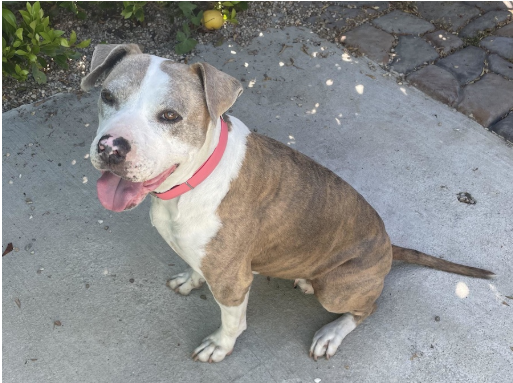

Does Stable Diffusion already know what she looks like?

**Task 6.3.2:** Generate four images with the prompt, "My dog Maya."

In [ ]:
images = pipeline(["My dog Maya"] * 4).images

for im in images:
    display(im)

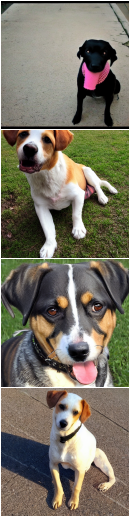

### Load Data Set for Fine Tuning

While Stable Diffusion can produce many cute looking dogs, it obviously doesn't know what Maya looks like.  And that's expected&mdash;clearly the model can't know what every dog in the entire world looks like!

We can fix that by fine-tuning the model on pictures of Maya.  To do this, we'll need a data set with pictures of Maya.  Luckily for us, this [data set already exists](https://huggingface.co/datasets/worldquant-university/maya-dataset-v1) on Hugging Face Hub!

Data sets on Hugging Face Hub are identified as `user/dataset`.

**Task 6.3.3:** Create a data set builder, which will let us access metadata about this data set.

In [ ]:
DATASET_NAME = "worldquant-university/maya-dataset-v1"
data_builder = datasets.load_dataset_builder(DATASET_NAME)

print(data_builder.dataset_name)

#output
maya-dataset-v1

This builder object has downloaded metadata about the data set.  This allows us to see what features are available, for example.

In [ ]:
print(data_builder.info.features)

#output
{'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None)}

**Task 6.3.4:** Determine which splits are included.  There is a `.splits` attribute in the `.info` property of our builder.

In [ ]:
print(data_builder.info.splits)

#output
{'train': SplitInfo(name='train', num_bytes=4324, num_examples=26, shard_lengths=None, dataset_name='maya-dataset-v1')}

This builder didn't download all of the data.  This is nice in general, since many data sets can be very large.  We can see above that there are only 26 rows in this dataset, so we can afford to download the whole thing.

**Task 6.3.5:** Load the Maya data set from Hugging Face Hub.

In [ ]:
data = datasets.load_dataset(DATASET_NAME)

print(data)

#output
DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 26
    })
})

This `DatasetDict` acts like a dictionary.  We can use key indexing to find the data itself.

In [ ]:
data["train"]["image"]

#output
[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x1600>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x2048>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1536x2048>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1536x2048>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024>]

**Task 6.3.6:** Display the fourth image. (Or take a look at more of them, if you like!)

In [ ]:
# The values are PIL images, so they will be displayed
# automatically by Jupyter.
data['train']['image'][3]

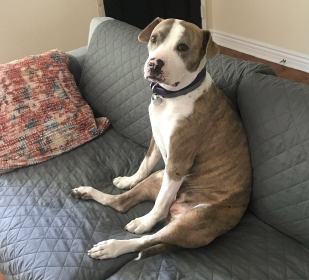

**Task 6.3.7:** Print out the text associated with each row in the training data.

In [ ]:
# Use dictionary indexing to look up the text values.
data['train']['text']

#output
['my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya',
 'my dog maya']

If the fine-tuning works, the model should figure out what "My dog Maya" looks like.

### LoRA Fine-tuning

We have the model and we have the data, so we're ready to do the LoRA fine-tuning.  The actual process is rather involved.  Luckily, we don't have to program it ourselves.  The diffusers project includes [a script](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py) that does LoRA fine-tuning of a Hugging Face model based on a Hugging Face data set.  There's a copy of this script in the same directory as this notebook: [`train_text_to_image_lora.py`](train_text_to_image_lora.py).

In addition to the model and data set names, we'll need to tell the script where to save the LoRA weights.  It's up to you, but we'd recommend `maya_model_v1_lora`.

In [ ]:
# train_text_to_image_lora.py

#!/usr/bin/env python
# coding=utf-8
# Copyright 2024 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Fine-tuning script for Stable Diffusion for text2image with support for LoRA."""

import argparse
import logging
import math
import os
import random
import shutil
from contextlib import nullcontext
from pathlib import Path

import datasets
import diffusers
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params, compute_snr
from diffusers.utils import (
    check_min_version,
    convert_state_dict_to_diffusers,
    is_wandb_available,
)
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module
from huggingface_hub import create_repo, upload_folder
from packaging import version
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

if is_wandb_available():
    import wandb

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.30.0.dev0")

logger = get_logger(__name__, log_level="INFO")


def save_model_card(
    repo_id: str,
    images: list = None,
    base_model: str = None,
    dataset_name: str = None,
    repo_folder: str = None,
):
    img_str = ""
    if images is not None:
        for i, image in enumerate(images):
            image.save(os.path.join(repo_folder, f"image_{i}.png"))
            img_str += f"![img_{i}](./image_{i}.png)\n"

    model_description = f"""
# LoRA text2image fine-tuning - {repo_id}
These are LoRA adaption weights for {base_model}. The weights were fine-tuned on the {dataset_name} dataset. You can find some example images in the following. \n
{img_str}
"""

    model_card = load_or_create_model_card(
        repo_id_or_path=repo_id,
        from_training=True,
        license="creativeml-openrail-m",
        base_model=base_model,
        model_description=model_description,
        inference=True,
    )

    tags = [
        "stable-diffusion",
        "stable-diffusion-diffusers",
        "text-to-image",
        "diffusers",
        "diffusers-training",
        "lora",
    ]
    model_card = populate_model_card(model_card, tags=tags)

    model_card.save(os.path.join(repo_folder, "README.md"))


def log_validation(
    pipeline,
    args,
    accelerator,
    epoch,
    is_final_validation=False,
):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=accelerator.device)
    if args.seed is not None:
        generator = generator.manual_seed(args.seed)
    images = []
    if torch.backends.mps.is_available():
        autocast_ctx = nullcontext()
    else:
        autocast_ctx = torch.autocast(accelerator.device.type)

    with autocast_ctx:
        for _ in range(args.num_validation_images):
            images.append(
                pipeline(
                    args.validation_prompt, num_inference_steps=30, generator=generator
                ).images[0]
            )

    for tracker in accelerator.trackers:
        phase_name = "test" if is_final_validation else "validation"
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images(phase_name, np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    phase_name: [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}")
                        for i, image in enumerate(images)
                    ]
                }
            )
    return images


def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default=None,
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--revision",
        type=str,
        default=None,
        required=False,
        help="Revision of pretrained model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--variant",
        type=str,
        default=None,
        help="Variant of the model files of the pretrained model identifier from huggingface.co/models, 'e.g.' fp16",
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that 🤗 Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--image_column",
        type=str,
        default="image",
        help="The column of the dataset containing an image.",
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",
        help="The column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--validation_prompt",
        type=str,
        default=None,
        help="A prompt that is sampled during training for inference.",
    )
    parser.add_argument(
        "--num_validation_images",
        type=int,
        default=4,
        help="Number of images that should be generated during validation with `validation_prompt`.",
    )
    parser.add_argument(
        "--validation_epochs",
        type=int,
        default=1,
        help=(
            "Run fine-tuning validation every X epochs. The validation process consists of running the prompt"
            " `args.validation_prompt` multiple times: `args.num_validation_images`."
        ),
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="sd-model-finetuned-lora",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument(
        "--seed", type=int, default=None, help="A seed for reproducible training."
    )
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help=(
            "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
            " cropped. The images will be resized to the resolution first before cropping."
        ),
    )
    parser.add_argument(
        "--random_flip",
        action="store_true",
        help="whether to randomly flip images horizontally",
    )
    parser.add_argument(
        "--train_batch_size",
        type=int,
        default=16,
        help="Batch size (per device) for the training dataloader.",
    )
    parser.add_argument("--num_train_epochs", type=int, default=100)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--gradient_checkpointing",
        action="store_true",
        help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps",
        type=int,
        default=500,
        help="Number of steps for the warmup in the lr scheduler.",
    )
    parser.add_argument(
        "--snr_gamma",
        type=float,
        default=None,
        help="SNR weighting gamma to be used if rebalancing the loss. Recommended value is 5.0. "
        "More details here: https://arxiv.org/abs/2303.09556.",
    )
    parser.add_argument(
        "--use_8bit_adam",
        action="store_true",
        help="Whether or not to use 8-bit Adam from bitsandbytes.",
    )
    parser.add_argument(
        "--allow_tf32",
        action="store_true",
        help=(
            "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
            " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
        ),
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument(
        "--adam_beta1",
        type=float,
        default=0.9,
        help="The beta1 parameter for the Adam optimizer.",
    )
    parser.add_argument(
        "--adam_beta2",
        type=float,
        default=0.999,
        help="The beta2 parameter for the Adam optimizer.",
    )
    parser.add_argument(
        "--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use."
    )
    parser.add_argument(
        "--adam_epsilon",
        type=float,
        default=1e-08,
        help="Epsilon value for the Adam optimizer",
    )
    parser.add_argument(
        "--max_grad_norm", default=1.0, type=float, help="Max gradient norm."
    )
    parser.add_argument(
        "--push_to_hub",
        action="store_true",
        help="Whether or not to push the model to the Hub.",
    )
    parser.add_argument(
        "--hub_token",
        type=str,
        default=None,
        help="The token to use to push to the Model Hub.",
    )
    parser.add_argument(
        "--prediction_type",
        type=str,
        default=None,
        help="The prediction_type that shall be used for training. Choose between 'epsilon' or 'v_prediction' or leave `None`. If left to `None` the default prediction type of the scheduler: `noise_scheduler.config.prediction_type` is chosen.",
    )
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument(
        "--local_rank",
        type=int,
        default=-1,
        help="For distributed training: local_rank",
    )
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
            " training using `--resume_from_checkpoint`."
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention",
        action="store_true",
        help="Whether or not to use xformers.",
    )
    parser.add_argument(
        "--noise_offset", type=float, default=0, help="The scale of noise offset."
    )
    parser.add_argument(
        "--rank",
        type=int,
        default=4,
        help=("The dimension of the LoRA update matrices."),
    )

    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    # Sanity checks
    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Need either a dataset name or a training folder.")

    return args


DATASET_NAME_MAPPING = {
    "lambdalabs/naruto-blip-captions": ("image", "text"),
}


def main():
    args = parse_args()
    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "You cannot use both --report_to=wandb and --hub_token due to a security risk of exposing your token."
            " Please use `huggingface-cli login` to authenticate with the Hub."
        )

    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(
        project_dir=args.output_dir, logging_dir=logging_dir
    )

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )

    # Disable AMP for MPS.
    if torch.backends.mps.is_available():
        accelerator.native_amp = False

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name,
                exist_ok=True,
                token=args.hub_token,
            ).repo_id
    # Load scheduler, tokenizer and models.
    noise_scheduler = DDPMScheduler.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="scheduler"
    )
    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
    )
    text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=args.revision,
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="vae",
        revision=args.revision,
        variant=args.variant,
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="unet",
        revision=args.revision,
        variant=args.variant,
    )
    # freeze parameters of models to save more memory
    unet.requires_grad_(False)
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Freeze the unet parameters before adding adapters
    for param in unet.parameters():
        param.requires_grad_(False)

    unet_lora_config = LoraConfig(
        r=args.rank,
        lora_alpha=args.rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    # Move unet, vae and text_encoder to device and cast to weight_dtype
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)

    # Add adapter and make sure the trainable params are in float32.
    unet.add_adapter(unet_lora_config)
    if args.mixed_precision == "fp16":
        # only upcast trainable parameters (LoRA) into fp32
        cast_training_params(unet, dtype=torch.float32)

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError(
                "xformers is not available. Make sure it is installed correctly"
            )

    lora_layers = filter(lambda p: p.requires_grad, unet.parameters())

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate
            * args.gradient_accumulation_steps
            * args.train_batch_size
            * accelerator.num_processes
        )

    # Initialize the optimizer
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
            )

        optimizer_cls = bnb.optim.AdamW8bit
    else:
        optimizer_cls = torch.optim.AdamW

    optimizer = optimizer_cls(
        lora_layers,
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
            data_dir=args.train_data_dir,
        )
    else:
        data_files = {}
        if args.train_data_dir is not None:
            data_files["train"] = os.path.join(args.train_data_dir, "**")
        dataset = load_dataset(
            "imagefolder",
            data_files=data_files,
            cache_dir=args.cache_dir,
        )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
    if args.image_column is None:
        image_column = (
            dataset_columns[0] if dataset_columns is not None else column_names[0]
        )
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
            )
    if args.caption_column is None:
        caption_column = (
            dataset_columns[1] if dataset_columns is not None else column_names[1]
        )
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
            )

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions,
            max_length=tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return inputs.input_ids

    # Preprocessing the datasets.
    train_transforms = transforms.Compose(
        [
            transforms.Resize(
                args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
            ),
            (
                transforms.CenterCrop(args.resolution)
                if args.center_crop
                else transforms.RandomCrop(args.resolution)
            ),
            (
                transforms.RandomHorizontalFlip()
                if args.random_flip
                else transforms.Lambda(lambda x: x)
            ),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = (
                dataset["train"]
                .shuffle(seed=args.seed)
                .select(range(args.max_train_samples))
            )
        # Set the training transforms
        train_dataset = dataset["train"].with_transform(preprocess_train)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = torch.stack([example["input_ids"] for example in examples])
        return {"pixel_values": pixel_values, "input_ids": input_ids}

    # DataLoaders creation:
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    # Scheduler and math around the number of training steps.
    # Check the PR https://github.com/huggingface/diffusers/pull/8312 for detailed explanation.
    num_warmup_steps_for_scheduler = args.lr_warmup_steps * accelerator.num_processes
    if args.max_train_steps is None:
        len_train_dataloader_after_sharding = math.ceil(
            len(train_dataloader) / accelerator.num_processes
        )
        num_update_steps_per_epoch = math.ceil(
            len_train_dataloader_after_sharding / args.gradient_accumulation_steps
        )
        num_training_steps_for_scheduler = (
            args.num_train_epochs
            * num_update_steps_per_epoch
            * accelerator.num_processes
        )
    else:
        num_training_steps_for_scheduler = (
            args.max_train_steps * accelerator.num_processes
        )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
    )

    # Prepare everything with our `accelerator`.
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        if (
            num_training_steps_for_scheduler
            != args.max_train_steps * accelerator.num_processes
        ):
            logger.warning(
                f"The length of the 'train_dataloader' after 'accelerator.prepare' ({len(train_dataloader)}) does not match "
                f"the expected length ({len_train_dataloader_after_sharding}) when the learning rate scheduler was created. "
                f"This inconsistency may result in the learning rate scheduler not functioning properly."
            )
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("text2image-fine-tune", config=vars(args))

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(
        f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
    )
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    for epoch in range(first_epoch, args.num_train_epochs):
        unet.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(
                    batch["pixel_values"].to(dtype=weight_dtype)
                ).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                if args.noise_offset:
                    # https://www.crosslabs.org//blog/diffusion-with-offset-noise
                    noise += args.noise_offset * torch.randn(
                        (latents.shape[0], latents.shape[1], 1, 1),
                        device=latents.device,
                    )

                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                )
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(
                    batch["input_ids"], return_dict=False
                )[0]

                # Get the target for loss depending on the prediction type
                if args.prediction_type is not None:
                    # set prediction_type of scheduler if defined
                    noise_scheduler.register_to_config(
                        prediction_type=args.prediction_type
                    )

                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(
                        f"Unknown prediction type {noise_scheduler.config.prediction_type}"
                    )

                # Predict the noise residual and compute loss
                model_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states, return_dict=False
                )[0]

                if args.snr_gamma is None:
                    loss = F.mse_loss(
                        model_pred.float(), target.float(), reduction="mean"
                    )
                else:
                    # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
                    # Since we predict the noise instead of x_0, the original formulation is slightly changed.
                    # This is discussed in Section 4.2 of the same paper.
                    snr = compute_snr(noise_scheduler, timesteps)
                    mse_loss_weights = torch.stack(
                        [snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1
                    ).min(dim=1)[0]
                    if noise_scheduler.config.prediction_type == "epsilon":
                        mse_loss_weights = mse_loss_weights / snr
                    elif noise_scheduler.config.prediction_type == "v_prediction":
                        mse_loss_weights = mse_loss_weights / (snr + 1)

                    loss = F.mse_loss(
                        model_pred.float(), target.float(), reduction="none"
                    )
                    loss = (
                        loss.mean(dim=list(range(1, len(loss.shape))))
                        * mse_loss_weights
                    )
                    loss = loss.mean()

                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
                train_loss += avg_loss.item() / args.gradient_accumulation_steps

                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    params_to_clip = lora_layers
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if global_step % args.checkpointing_steps == 0:
                    if accelerator.is_main_process:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [
                                d for d in checkpoints if d.startswith("checkpoint")
                            ]
                            checkpoints = sorted(
                                checkpoints, key=lambda x: int(x.split("-")[1])
                            )

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = (
                                    len(checkpoints) - args.checkpoints_total_limit + 1
                                )
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(
                                    f"removing checkpoints: {', '.join(removing_checkpoints)}"
                                )

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(
                                        args.output_dir, removing_checkpoint
                                    )
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(
                            args.output_dir, f"checkpoint-{global_step}"
                        )
                        accelerator.save_state(save_path)

                        unwrapped_unet = unwrap_model(unet)
                        unet_lora_state_dict = convert_state_dict_to_diffusers(
                            get_peft_model_state_dict(unwrapped_unet)
                        )

                        StableDiffusionPipeline.save_lora_weights(
                            save_directory=save_path,
                            unet_lora_layers=unet_lora_state_dict,
                            safe_serialization=True,
                        )

                        logger.info(f"Saved state to {save_path}")

            logs = {
                "step_loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        if accelerator.is_main_process:
            if (
                args.validation_prompt is not None
                and epoch % args.validation_epochs == 0
            ):
                # create pipeline
                pipeline = DiffusionPipeline.from_pretrained(
                    args.pretrained_model_name_or_path,
                    unet=unwrap_model(unet),
                    revision=args.revision,
                    variant=args.variant,
                    torch_dtype=weight_dtype,
                )
                images = log_validation(pipeline, args, accelerator, epoch)

                del pipeline
                torch.cuda.empty_cache()

    # Save the lora layers
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unet.to(torch.float32)

        unwrapped_unet = unwrap_model(unet)
        unet_lora_state_dict = convert_state_dict_to_diffusers(
            get_peft_model_state_dict(unwrapped_unet)
        )
        StableDiffusionPipeline.save_lora_weights(
            save_directory=args.output_dir,
            unet_lora_layers=unet_lora_state_dict,
            safe_serialization=True,
        )

        # Final inference
        # Load previous pipeline
        if args.validation_prompt is not None:
            pipeline = DiffusionPipeline.from_pretrained(
                args.pretrained_model_name_or_path,
                revision=args.revision,
                variant=args.variant,
                torch_dtype=weight_dtype,
            )

            # load attention processors
            pipeline.load_lora_weights(args.output_dir)

            # run inference
            images = log_validation(
                pipeline, args, accelerator, epoch, is_final_validation=True
            )

        if args.push_to_hub:
            save_model_card(
                repo_id,
                images=images,
                base_model=args.pretrained_model_name_or_path,
                dataset_name=args.dataset_name,
                repo_folder=args.output_dir,
            )
            upload_folder(
                repo_id=repo_id,
                folder_path=args.output_dir,
                commit_message="End of training",
                ignore_patterns=["step_*", "epoch_*"],
            )

    accelerator.end_training()


if __name__ == "__main__":
    main()



**Task 6.3.8:** Set the `OUTPUT_DIR` variable with the correct value.

In [ ]:
OUTPUT_DIR = "maya_model_v1_lora"

**Task 6.3.9:** Inspect the `train_text_to_image_lora.py` script.

**Due to GPU limitations you CAN NOT run this script.**

It's an advanced (and long) script. But if you want, take a look at it to familiarize yourself with the process of fine tuning.

### Load LoRA Weights

Now that we have the LoRA weights, we can load them into the pipeline we already have.  The pipeline has a `.load_lora_weights()` method that can take a directory path as an argument.  The file name of the weights file is given separately in the `weight_name` argument.

**Task 6.3.10:** Load the LoRA weights into our pipeline.

In [ ]:
pipeline.load_lora_weights(
    OUTPUT_DIR, # Directory containing weights file

    weight_name="pytorch_lora_weights.10_epochs.safetensors",
)

**Task 6.3.11:** Generate four images of "My dog Maya" with the fine-tuned model.

In [ ]:
images = pipeline(['My dog Maya'] * 4).images

for im in images:
    display(im)

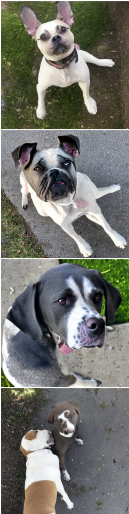

These should look (a bit) more like Maya!

# Conclusion

You've now used the fine-tuned model to produce images of our dog Maya that look (a bit more) like her.  If we had more training data and had trained for more epochs, perhaps the model would perform even better.  By using the LoRA algorithm, we could do the fine-tuning with only a fraction of the parameters in the original model.  (Note that the file containing the LoRA weights is about 3 MB in size.  The full weights for the Stable Diffusion model are about 3 GB in size!)

In the process, we've learned:
- How to download data sets from Hugging Face.
- How to run LoRA from a script.
- How to load the LoRA weights into a Stable Diffusion pipeline.
- How to set up a Hugging Face token for API access.
- How to upload weights to Hugging Face repository.

In the next lesson, we'll use our fine-tuned model as a component in a Streamlit web app.